In [1]:
from model import GeoCLIP
from model import ImageEncoder
from model import LocationEncoder
from train import train
import dataloader
import os
from torch import nn
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb
import os
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

# WANDB_MODE="disabled"
# os.environ['WANDB_MODE'] = 'disabled'


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def haversine_distance(lon1, lat1, lon2, lat2):
    '''Find distance between locations in meters'''

    R = 6371000 # radius of Earth in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = (np.sin(delta_phi / 2))**2 + np.cos(phi1) * np.cos(phi2) * (np.sin(delta_lambda / 2))**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [3]:
df_gsv10k = pd.read_csv('/workspace/GSW10k/dataset/coords.csv', header=None)
df_gsv10k.columns = ['lat', 'lon']
df_gsv10k

,lat,lon
0,20.824885,-98.499517
1,-3.451752,-54.563937
2,-23.496464,-47.460542
3,-16.548678,-72.852778
4,-35.010870,140.064397
...,...,...
9995,11.529776,8.653117
9996,-20.213648,-50.071765
9997,55.640605,52.702265
9998,-33.285317,146.590469


In [4]:
class GSV10kDataset(torch.utils.data.Dataset):
    def __init__(self, root, df, transform=None, transform_aug=None):
        self.root = root
        self.df = df
        self.transform = transform
        self.transform_aug = transform_aug
        self.n_aug = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # gps is of format [Lat, lon]
        gps = self.df.iloc[idx].values
        gps = torch.tensor(gps, dtype=torch.float32)
        img = Image.open(os.path.join(self.root, f'{idx}.png'))
        # if self.transform_aug:
        img_1 = self.transform_aug(img)
        augmented_images = torch.empty((self.n_aug,) + img_1.shape, dtype=torch.float32)
        augmented_images[0] = img_1
        for i in range(1, self.n_aug):
            augmented_images[i] = self.transform_aug(img)
        # print(augmented_images.shape, gps.shape)
        return augmented_images, gps

In [5]:
df_amman = pd.read_csv("/workspace/mappilary_street_level/train_val/amman/query/raw.csv")
df_amman["city"] = "amman"

df_saopaolo = pd.read_csv("/workspace/mappilary_street_level/train_val/saopaulo/query/raw.csv")
df_saopaolo["city"] = "saopaulo"

In [6]:
df_amman.pano.sum(), df_saopaolo.pano.sum()

(0, 0)

In [7]:
df = pd.read_csv("/workspace/mappilary_street_level/train_val/amsterdam/query/raw.csv")
# Add a column for the city
df["city"] = "amsterdam"
# Concatenate df to include all three cities
df = pd.concat([df_amman, df_saopaolo, df])

df_no_panorama = df[~df["pano"]]

In [8]:
df_distance = df_no_panorama[["lat", "lon"]].values
distances_map = dict()
min_distance = 100
start_coords = df_distance[0]
for i in range(1, len(df_distance)):
    dist = haversine_distance(start_coords[1], start_coords[0], df_distance[i][1], df_distance[i][0])
    if dist >= min_distance:
        start_coords = df_distance[i]
        distances_map[i] = dist

In [9]:
selected_images_no_jpg = df_no_panorama.iloc[list(distances_map.keys())].key.values
selected_images = [f"{img}.jpg" for img in selected_images_no_jpg]
gps_coords = list(distances_map.keys())

In [10]:
data_df = df_no_panorama[df_no_panorama["key"].isin(selected_images_no_jpg)]
data_df["key"] = data_df["key"].apply(lambda x: f"{x}.jpg")
data_df = data_df.reset_index(drop=True)
data_df.head()

/tmp/ipykernel_5846/1918851640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["key"] = data_df["key"].apply(lambda x: f"{x}.jpg")


,Unnamed: 0,key,lon,lat,ca,captured_at,pano,city
0,6,PLe0G5q77pb0x4LClijoXQ.jpg,35.832118,31.984423,326.626160,2018-10-05,False,amman
1,13,VhJ5BeSfetHiPsh72JT9xQ.jpg,35.831623,31.985298,338.397583,2018-10-05,False,amman
2,20,_ep329_BkMNWPCsK0KZ1Vg.jpg,35.831150,31.986421,340.933899,2018-10-05,False,amman
3,22,pKhc6vODctQT14eATpg8gQ.jpg,35.830637,31.988314,354.362183,2018-10-05,False,amman
4,28,XoaiPqugnaPkkLoOzS9hGQ.jpg,35.830489,31.989263,353.074585,2018-10-05,False,amman


In [11]:
# Filter all rows where key is in selected_images_no_jpg
df_keys = df_no_panorama[df_no_panorama["key"].isin(selected_images_no_jpg)][["lon", "lat"]]
np_keys = df_keys.reset_index(drop=True, inplace=False).values

In [12]:
df_no_panorama[["lat", "lon"]].describe()

,lat,lon
count,21847.000000,21847.000000
mean,-14.410867,-38.756965
std,23.825817,21.050730
min,-23.626103,-46.918485
25%,-23.583337,-46.712906
50%,-23.550212,-46.664795
75%,-23.523810,-46.600607
max,52.457840,35.931735


In [13]:
df_keys.describe()

,lon,lat
count,2411.000000,2411.000000
mean,-34.707703,-9.172369
std,24.496458,28.805653
min,-46.917779,-23.626103
25%,-46.725307,-23.583154
50%,-46.660255,-23.546962
75%,-46.579327,-23.515020
max,35.931735,52.457840


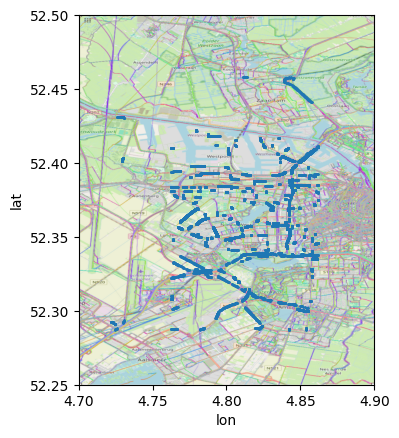

In [14]:
df[['lat', 'lon']].plot(kind='scatter', x='lon', y='lat', s=1)
# overlay map on top of scatter plot
img = Image.open("/workspace/mappilary_street_level/amsterdam.png")
plt.imshow(img, extent=[4.7, 4.9, 52.250, 52.5])

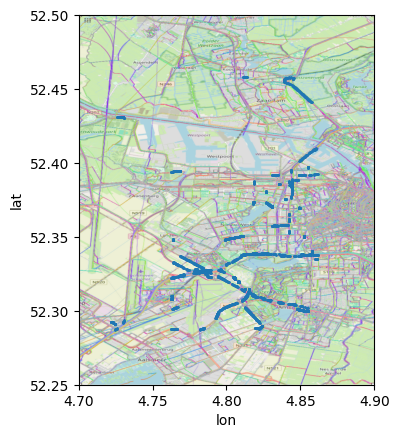

In [15]:
df_no_panorama[['lat', 'lon']].plot(kind='scatter', x='lon', y='lat', s=1)
# overlay map on top of scatter plot
img = Image.open("/workspace/mappilary_street_level/amsterdam.png")
plt.imshow(img, extent=[4.7, 4.9, 52.250, 52.5])

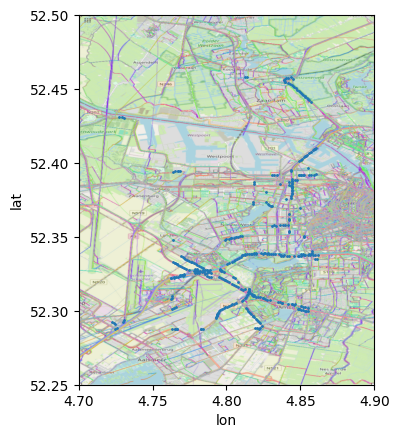

In [16]:
df_keys.plot.scatter(x="lon", y="lat", s=1)
# overlay map on top of scatter plot
img = Image.open("/workspace/mappilary_street_level/amsterdam.png")
plt.imshow(img, extent=[4.7, 4.9, 52.250, 52.5])

In [17]:
torch.empty((4,) + (256, 256), dtype=torch.float32).shape

torch.Size([4, 256, 256])

In [18]:
class AmsterdamData(torch.utils.data.Dataset):
    def __init__(self, root: str, prefix: str, data_df: pd.DataFrame, transform_aug=None, transform=None):
        self.root = root
        self.transform = transform
        self.transform_aug = transform_aug
        self.data_df = data_df
        self.prefix = prefix
        self.n_aug = 2

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        gps = data_df.iloc[idx][["lat", "lon"]].values
        # TODO: check lat lon correct and not lon lat
        gps = gps.astype(np.float64)
        gps = torch.tensor(gps, dtype=torch.float32)
        img_path = data_df.iloc[idx]["key"]
        city = data_df.iloc[idx]["city"]
        img = Image.open(os.path.join(self.root, city, self.prefix, img_path))
        # if self.transform_aug:
        img_1 = self.transform_aug(img)
        augmented_images = torch.empty((self.n_aug,) + img_1.shape, dtype=torch.float32)
        augmented_images[0] = img_1
        #pdb.set_trace()
        for i in range(1, self.n_aug):
            #print(i)
            augmented_images[i] = self.transform_aug(img)

        return augmented_images, gps

In [19]:
class ContrastiveQueueLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.1):
        super(ContrastiveQueueLoss, self).__init__()
        self.temperature = temperature
        self.batch_size = batch_size

    def forward(self, V: torch.Tensor, L: torch.Tensor, queue: torch.Tensor) -> torch.Tensor:
        '''
        V: torch.Tensor
            size (n_aug, batch_size, feature_size)
        L: torch.Tensor
            size (batch_size, feature_size)
        queue: torch.Tensor
            size (queue_size, feature_size)
        '''
        #pdb.set_trace()
        loss = 0
        k = 0
        for uber_i in range(V.shape[1]):
            loss_uber_i = 0
            denominator = 0
            for j in range(V.shape[0]):
                numerator = (V[j, uber_i] @ L[uber_i].T) / self.temperature

                bat_shit_denominator = 0
                for i in range(V.shape[1]):
                    image_vec_list = V[j,i]
                    bat_shit_denominator += torch.exp((image_vec_list @ L[i].T) / self.temperature)

                q_shit_denominator = 0
                for i in range(queue.shape[0]):
                    image_vec_list = V[j, uber_i]
                    q_shit_denominator += torch.exp((image_vec_list @ queue[i].T) / self.temperature)

                denominator = torch.log(bat_shit_denominator + q_shit_denominator)
                loss_uber_i += numerator - denominator
                wandb.log({"numerator": numerator, "denominator": denominator, "loss_uber_i": loss_uber_i})
                k += 1
            loss -= loss_uber_i
        return loss

In [20]:
from typing import Tuple, Union
class MemoryBankModule(nn.Module):
    """
    Implementation from https://github.com/lightly-ai/lightly/blob/master/lightly/loss/ntx_ent_loss.py
    """
    def __init__(
            self,
            size: int = 4096,
        ):
            super().__init__()
            self.size = size
            self.bank: torch.Tensor
            self.register_buffer(
                "bank",
                tensor=torch.empty(size=size, dtype=torch.float),
                persistent=False,
            )
            self.bank_ptr: torch.Tensor
            self.register_buffer(
                "bank_ptr",
                tensor=torch.empty(1, dtype=torch.long),
                persistent=False,
            )

    @torch.no_grad()
    def _init_memory_bank(self, size: int) -> None:
        """Initialize the memory bank.

        Args:
            size:
                Size of the memory bank as (num_features, dim) tuple.

        """
        self.bank = torch.randn(size).type_as(self.bank)
        self.bank = torch.nn.functional.normalize(self.bank, dim=-1)
        self.bank_ptr = torch.zeros(1).type_as(self.bank_ptr)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, batch: torch.Tensor) -> None:
        """Dequeue the oldest batch and add the latest one

        Args:
            batch:
                The latest batch of keys to add to the memory bank.

        """

        batch_size = batch.shape[0]
        ptr = int(self.bank_ptr)
        if ptr + batch_size >= self.size[0]:
            self.bank[ptr:] = batch[: self.size[0] - ptr].detach()
            self.bank_ptr.zero_()
        else:
            self.bank[ptr : ptr + batch_size] = batch.detach()
            self.bank_ptr[0] = ptr + batch_size

    def forward(
        self,
        output: torch.Tensor,
        update: bool = False,
    ) -> Tuple[torch.Tensor, Union[torch.Tensor, None]]:
        """Query memory bank for additional negative samples

        Args:
            output:
                The output of the model.
            update:
                If True, the memory bank will be updated with the current output.

        Returns:
            The output if the memory bank is of size 0, otherwise the output
            and the entries from the memory bank. Entries from the memory bank have
            shape (dim, num_features) if feature_dim_first is True and
            (num_features, dim) otherwise.
        """

        # no memory bank, return the output
        if self.size[0] == 0:
            return output, None

        # Initialize the memory bank if it is not already done.
        if self.bank.ndim == 1:
            dim = output.shape[1:]
            self._init_memory_bank(size=(*self.size, *dim))

        # query and update memory bank
        bank = self.bank.clone().detach()
        if self.feature_dim_first:
            # swap bank size and feature dimension for backwards compatibility
            bank = bank.transpose(0, -1)

        # only update memory bank if we later do backward pass (gradient)
        if update:
            self._dequeue_and_enqueue(output)

        return output, bank

class NTXentLoss(MemoryBankModule):
    """        
    Implementation from https://github.com/lightly-ai/lightly/blob/master/lightly/loss/ntx_ent_loss.py
    """

    def __init__(self, temp: float = 0.01, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.temperature = temp

    def forward(self, img_emb: Tuple[torch.Tensor, torch.Tensor], gps_emb: torch.Tensor, gps_emb_q: torch.Tensor):
        # Forward pass for MOCO inspired setup 
        # with a queue for negative samples
        # x0 and x1 are the augmented images
        # gps_feat_q is the queue of negative samples
        x0, x1 = img_emb

        device = x0.device
        # Normalize the features
        x0 = F.normalize(x0, dim=1)
        x1 = F.normalize(x1, dim=1)

        # This gets the negative samples from the queue
        #x1, negatives = super(NTXentLoss, self).forward(x1, update=x0.required_grad)

        c_0 = x0.dot(gps_emb)
        c_1 = x1.dot(gps_emb)
        sim_pos = c_0.dot(c_1)
        sim_neg = c_0.dot(gps_emb_q) # negatives

        logits = torch.cat([sim_pos, sim_neg], dim=1) / self.temperature
        # Zeros implies that the first index is the correct class for the image (the positive sample)
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=device)

        loss = F.cross_entropy(logits, labels)
        return loss

        

In [21]:
def device_as(t1, t2):
   """
   Moves t1 to the device of t2
   """
   return t1.to(t2.device)

class SimCLRLoss(nn.Module):

    def __init__(self, batch_size: int, temperature: int):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()


    def calc_similarity_batch(self, a: torch.Tensor, b: torch.Tensor):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        
    def forward(self, proj_1: torch.Tensor, proj_2: torch.Tensor):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        # Postive similarities are on the off-diagonals
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        # Mask out the main diagonal and calculate the softmax
        denominator = (self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss

In [22]:
class BestModel(nn.Module):
    def __init__(self, image_encoder, location_encoder):
        super(BestModel, self).__init__()
        self.Geoclip = GeoCLIP()
        for param in self.Geoclip.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(512, 512)

    def forward(self, image, location):
        x = self.Geoclip(image, location)
        return self.fc(x)



In [23]:
def img_augment_transform():
    train_transform_list = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return train_transform_list

def img_transform():
    train_transform_list = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return train_transform_list

In [24]:
EPOCHS = 2
BATCH_SIZE = 512

In [25]:
geo_clip = GeoCLIP(batch_size=BATCH_SIZE, device="cuda:0")
geo_clip.to("cuda:0")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


GeoCLIP(
  (image_encoder): ImageEncoder(
    (CLIP): CLIPModel(
      (text_model): CLIPTextTransformer(
        (embeddings): CLIPTextEmbeddings(
          (token_embedding): Embedding(49408, 768)
          (position_embedding): Embedding(77, 768)
        )
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-11): 12 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): CLIPMLP(
                (activation_fn): QuickGELUActivation()
                (fc1): Linear(in_features=768, out_features=3072, bias=True)
            

In [26]:
LEARNING_RATE = 1e-5
TEMPERATURE = 0.1
GAMMA = 0.1
STEP_SIZE = 10
optim = torch.optim.SGD(geo_clip.parameters(), lr=LEARNING_RATE)
criterion = ContrastiveQueueLoss(batch_size=BATCH_SIZE, temperature=TEMPERATURE) #SimCLRLoss(BATCH_SIZE, 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=STEP_SIZE, gamma=GAMMA)
dataset = AmsterdamData(root="/workspace/mappilary_street_level/train_val/",
                        prefix="query/images",
                        data_df=data_df,
                        transform=img_transform(),
                        transform_aug=img_augment_transform())
dataset = GSV10kDataset(root="/workspace/GSW10k/dataset/",
                        df=df_gsv10k,
                        transform=img_transform(),
                        transform_aug=img_augment_transform())


In [27]:
# split dataset into train test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [28]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="snowclip",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "dataset": "amsterdam",
    "architecture": "geoclip",
    "optimizer": "SGD",
    "scheduler": {"StepLR": {"step_size": STEP_SIZE, "gamma": GAMMA}},
    "loss": {"contrastive_queue_loss": {"temperature": TEMPERATURE}},
    "augmentation": "RandomResizedCrop, RandomHorizontalFlip, RandomApply, RandomGrayscale",
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: timothy-lindblom. Use `wandb login --relogin` to force relogin


In [29]:
#images, gps = next(iter(loader))

In [30]:
def imshow(img):
    img = img / 1.75 #+ 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#for i in range(BATCH_SIZE):
#    imshow(torchvision.utils.make_grid(images[i]))


In [31]:
#wandb.finish()

In [32]:
def test(loader, model, criterion, optim, scheduler, epoch, batch_size, device="cuda:0", test_val="test"):
    epoch_loss = 0
    for i, (imgs, gps) in enumerate(loader):
        optim.zero_grad()
        imgs = imgs.to(device)
        gps = gps.to(device)

        torch.no_grad()
        img_features_view_1 = model.image_encoder(imgs[:, 0])
        img_features_view_2 = model.image_encoder(imgs[:, 1])
        gps_features = model.location_encoder(gps)
        gps_features = F.normalize(gps_features, dim=1)

        # Append Queue
        gps_features_q = model.append_gps_queue_features(gps_features, gps)

        img_features_view_1 = torch.unsqueeze(img_features_view_1, 0)
        img_features_view_2 = torch.unsqueeze(img_features_view_2, 0)
        loss = criterion(
            torch.cat((img_features_view_1, img_features_view_2), dim=0),
            gps_features,
            gps_features_q)
        epoch_loss += loss.item() / batch_size
        torch.enable_grad()
    wandb.log({"epoch": epoch, f"{test_val}_loss": epoch_loss / len(loader)})

In [33]:
run.watch(models=geo_clip, log="all")
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for fold, (train_index, test_index) in enumerate(kf.split(train_dataset)):
    train_loader = DataLoader(Subset(dataset, train_index), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(Subset(dataset, test_index), batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(EPOCHS):
        train(train_loader, geo_clip, criterion, optim, scheduler, epoch=epoch+1, batch_size=BATCH_SIZE, device="cuda:0")
        print("Starting test, epoch:", epoch)
        test(test_loader, geo_clip, criterion, optim, epoch=epoch+1, batch_size=BATCH_SIZE, device="cuda:0")
        # Get validation loss
        test(validation_loader, geo_clip, criterion, optim, epoch=epoch+1, batch_size=BATCH_SIZE, device="cuda:0", test_val="val")

wandb.finish()

  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size

/tmp/ipykernel_5846/894531757.py:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  numerator = (V[j, uber_i] @ L[uber_i].T) / self.temperature
Epoch 1 loss: 10390.64941:   6%|▋         | 1/16 [15:52<3:58:14, 953.00s/it]

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size

Epoch 1 loss: 25771.92969:  12%|█▎        | 2/16 [38:46<4:40:03, 1200.25s/it]

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size

Epoch 1 loss: 17778.69922:  19%|█▉        | 3/16 [1:12:31<5:41:40, 1576.93s/it]

torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size([2, 3, 224, 224]) torch.Size([2])
torch.Size

: 

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")
print(inputs["pixel_values"].shape)
#image_features = model.get_image_features(**inputs)

torch.Size([1, 3, 224, 224])


In [ ]:
image = Image.open("/workspace/geoclip/images/Kauai.png")
image = geo_clip.image_encoder.preprocess_image(image=image)
image = image.to("cuda:0")
top_k = 10
gps_gallery = geo_clip.gps_gallery.to("cuda:0")

logits_per_image, logits_per_location = geo_clip.forward(image, gps_gallery)
probs_per_image = logits_per_image.softmax(dim=-1).cpu()

# Get top k prediction
top_pred = torch.topk(probs_per_image, top_k, dim=1)
top_pred_gps = geo_clip.gps_gallery[top_pred.indices[0]]
top_pred_prob = top_pred.values[0]

In [ ]:
top_pred_gps, top_pred_prob

(tensor([[  51.4483,   -1.0084],
         [  45.4317,   12.3301],
         [  19.4127,  -99.1689],
         [  25.6154, -100.3496],
         [  25.2321,   55.2643],
         [  38.9429, -119.9759],
         [  34.2010, -118.5999],
         [ -50.9434,  -72.9357],
         [  48.8400,   -3.5049],
         [  18.4915,  -69.9589]]),
 tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        grad_fn=<SelectBackward0>))